# Readme
这个notebook画图从统计学上的解释性，包括：
1. 消融分析

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import copy
import argparse
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import json
from utils.tools import dotdict
import seaborn as sns

from collections import OrderedDict
from matplotlib.pyplot import MultipleLocator
from matplotlib import cm
from scipy import stats
import math
from scipy.optimize import curve_fit
import matplotlib
from data_provider.data_loader import fixed_files
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error

from matplotlib.font_manager import FontProperties
from scipy.stats import wilcoxon, ttest_ind, mannwhitneyu

font = {'family' : 'Arial'}

matplotlib.rcParams['mathtext.fontset'] = 'custom'

matplotlib.rcParams['mathtext.rm'] = 'Arial'

matplotlib.rcParams['mathtext.it'] = 'Arial'

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42 # make the text editable for Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rc('font', **font0)

# matplotlib.rc('text', usetex=False)
def set_ax_linewidth(ax, bw=1.5):
    ax.spines['bottom'].set_linewidth(bw)
    ax.spines['left'].set_linewidth(bw)
    ax.spines['top'].set_linewidth(bw)
    ax.spines['right'].set_linewidth(bw)

def set_ax_font_size(ax, fontsize=10):
    ax.tick_params(axis='y',
                 labelsize=fontsize # y轴字体大小设置
                  ) 
    ax.tick_params(axis='x',
                 labelsize=fontsize # x轴字体大小设置
                  ) 

def set_draft(the_plt, other_ax=''):
    ax = the_plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.xlabel('')
    plt.ylabel('')
    if other_ax:
        other_ax.axes.xaxis.set_ticklabels([])
        other_ax.axes.yaxis.set_ticklabels([])
        other_ax.set_ylabel('')
        other_ax.set_xlabel('')

def set_draft_fig(fig):
    for ax in fig.axes:
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.set_ylabel('')
        ax.set_xlabel('')
    
x_y_label_size = 12 
title_size = 12 
convert_mm_to_inch = 1/25.4
dot_size = 9

metric = 'mae' # mae or rmse

In [6]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def plot_significane(ax, Xs,Ys,P_value,height=0.2):
    '''
    ax: The matplotlib.axes to conduct the plot
    Xs: The x-coordinates of the line
    Ys: The y-coordinates of the line
    P_value: The significance test value
    height: The vertical line height
    '''
    # plot the line
    Ys[1] += height
    Ys[2] += height
    ax.plot(Xs, Ys, lw=2, c='#595959')
    ax.text((Xs[0]+Xs[2])*0.5, Ys[0]+height,convert_pvalue_to_asterisks(P_value), ha='center', va='bottom', color="k")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

label = ['G1', 'G2', 'G3', 'G4', 'G5']
first = [20, 34, 30, 35, 27]
second = [25, 32, 34, 20, 25]
third = [21, 31, 37, 21, 28]
fourth = [26, 31, 35, 27, 21]
data = [first, second, third, fourth]


def create_multi_bars(ax,title, labels, datas,colors, ylabel=r'alpha-accuracy',ylim=(0.4,1.0), tick_step=1.2, group_gap=0.2, bar_gap=0, y_step=0.1):
    '''
    ax: 绘图所在的轴
    labels : x轴坐标标签序列
    datas ：数据集，二维列表，要求列表每个元素的长度必须与labels的长度一致
    colors: 绘制每个柱子的颜色，长度必须与datas的长度一致
    tick_step ：默认x轴刻度步长为1，通过tick_step可调整x轴刻度步长。
    group_gap : 柱子组与组之间的间隙，最好为正值，否则组与组之间重叠
    bar_gap ：每组柱子之间的空隙，默认为0，每组柱子紧挨，正值每组柱子之间有间隙，负值每组柱子之间重叠
    '''
    # ticks为x轴刻度
    ticks = np.arange(len(labels)) * tick_step
    # group_num为数据的组数，即每组柱子的柱子个数
    group_num = len(datas)
    # group_width为每组柱子的总宽度，group_gap 为柱子组与组之间的间隙。
    group_width = tick_step - group_gap
    # bar_span为每组柱子之间在x轴上的距离，即柱子宽度和间隙的总和
    bar_span = group_width / group_num
    # bar_width为每个柱子的实际宽度
    bar_width = bar_span - bar_gap
    # baseline_x为每组柱子第一个柱子的基准x轴位置，随后的柱子依次递增bar_span即可
    baseline_x = ticks - (group_width - bar_span) / 2
    for index, y in enumerate(datas):
        ax.bar(baseline_x + index*bar_span, y, bar_width, color=colors[index])
    ax.set_ylabel(ylabel,fontsize=10)
    ax.set_title(title,fontsize=10)
    y_major_locator=MultipleLocator(y_step)
    set_ax_linewidth(ax)
    set_ax_font_size(ax)
    ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylim(ylim)

    # x轴刻度标签位置与x轴刻度一致
    ax.set_xticks(ticks, labels, fontsize=8)

def plot_ablation_study_beforeZTY(NCA_model_paths, LFP_model_paths, NCA_target_condition, LFP_unseen_conditions):
    def collect_preds(cycleNumber_preds):
        '''Collect the preds from each cycle number'''
        cycleNumber_preds = list(cycleNumber_preds.values())
        total_preds = []
        for preds in cycleNumber_preds:
            total_preds += [np.mean(preds,axis=1)]
        total_preds = np.concatenate(total_preds,axis=0)
        return total_preds
    
    fig,(ax1,ax2) = plt.subplots(1,2,
                                    figsize=(10,2),
                                    dpi=600)
    ''' 根据trajectory上的每一个预测值来做显著性分析 '''
    colors = ['#f08080','#b1bfcd', '#e8c6bb', '#1e90ff']
    model_names = ['RBDPNet','w/o TSL', 'w/o DG','w/o Both'] # the model names
    
    NCA_model_scores = {} # 一个字典，用于保存Key为model name, value为overall, target, source的alpha-acc
    LFP_model_scores = {} # 一个字典，用于保存Key为model name，value为overall, unseen, seen的alpha-acc
    plot_NCA_paths = []
    plot_LFP_paths = []
    plot_colors = []
    plot_labels = []
    for index in range(len(NCA_model_paths)):
        NCA_mp = NCA_model_paths[index]
        LFP_mp = LFP_model_paths[index]
        the_color = colors[index]

        plot_colors.append(the_color) # 绘图颜色
        plot_NCA_paths.append(NCA_mp)
        plot_LFP_paths.append(LFP_mp)
        plot_labels.append(model_names[index])

        with open(f'{NCA_mp}alpha_scores_Qd.json') as f:
            NCA_alphas = json.load(f)
            tmp_target_score = []
            tmp_source_score = []
            for condition, score in NCA_alphas.items():
                if condition == NCA_target_condition:
                    tmp_target_score += [np.mean(score)]
                else:
                    tmp_source_score += [np.mean(score)]
            tmp_total_score = tmp_target_score + tmp_source_score
            NCA_scores_Qd = np.array([np.mean(tmp_total_score), np.mean(tmp_target_score), np.mean(tmp_source_score)])
        with open(f'{NCA_mp}alpha_scores_Ed.json') as f:
            NCA_alphas = json.load(f)
            tmp_target_score = []
            tmp_source_score = []
            for condition, score in NCA_alphas.items():
                if condition == NCA_target_condition:
                    tmp_target_score += [np.mean(score)]
                else:
                    tmp_source_score += [np.mean(score)]
            tmp_total_score = tmp_target_score + tmp_source_score
            NCA_scores_Ed = np.array([np.mean(tmp_total_score), np.mean(tmp_target_score), np.mean(tmp_source_score)])
        NCA_model_scores[model_names[index]] = (NCA_scores_Qd+NCA_scores_Ed) / 2

        # get the Qd scores
        with open(f'{LFP_mp}alpha_scores_Qd.json') as f:
            LFP_alphas = json.load(f)
            tmp_unseen_score = []
            tmp_seen_score = []
            for condition, score in LFP_alphas.items():
                if condition in LFP_unseen_conditions:
                    tmp_unseen_score += [np.mean(score)]
                else:
                    tmp_seen_score += [np.mean(score)]
            tmp_total_score = tmp_unseen_score + tmp_seen_score
            LFP_scores_Qd = np.array([np.mean(tmp_total_score), np.mean(tmp_unseen_score), np.mean(tmp_seen_score)])
        # get the Ed scores
        with open(f'{LFP_mp}alpha_scores_Ed.json') as f:
            LFP_alphas = json.load(f)
            tmp_unseen_score = []
            tmp_seen_score = []
            for condition, score in LFP_alphas.items():
                if condition in LFP_unseen_conditions:
                    tmp_unseen_score += [np.mean(score)]
                else:
                    tmp_seen_score += [np.mean(score)]
            tmp_total_score = tmp_unseen_score + tmp_seen_score
            LFP_scores_Ed = np.array([np.mean(tmp_total_score), np.mean(tmp_unseen_score), np.mean(tmp_seen_score)])
        LFP_model_scores[model_names[index]] = (LFP_scores_Qd+LFP_scores_Ed) / 2


    # 画NCA的那个图
    create_multi_bars(ax1,'NCA', ['Overall', 'Target', 'Source'], list(NCA_model_scores.values()), plot_colors)
    # 画LFP的那个图
    create_multi_bars(ax2,'LFP', ['Overall', 'Unseen', 'Seen'], list(LFP_model_scores.values()), plot_colors,r'alpha-accuracy',(0.85,1.0), y_step=0.05)
    plt.savefig('./fig4/ablation.pdf', bbox_inches = 'tight', format='pdf')
    plt.show()

def plot_ablation_study(NCA_model_paths, LFP_model_paths, NCA_target_condition, LFP_unseen_conditions):
    def collect_preds(cycleNumber_preds):
        '''Collect the preds from each cycle number'''
        cycleNumber_preds = list(cycleNumber_preds.values())
        total_preds = []
        for preds in cycleNumber_preds:
            total_preds += [np.mean(preds,axis=1)]
        total_preds = np.concatenate(total_preds,axis=0)
        return total_preds
    
    fig = plt.figure(figsize=(11,2.5))
    ''' 根据trajectory上的每一个预测值来做显著性分析 '''
    colors = ['#f08080','#b1bfcd', '#e8c6bb', '#1e90ff']
    model_names = ['MAGNet','w/o TDDG', 'w/o MLDG','w/o Both'] # the model names
    
    model_scores = {} # 一个字典，用于保存Key为model name, value为overall, target, source, unseen的alpha-acc
    plot_NCA_paths = []
    plot_LFP_paths = []
    plot_colors = []
    plot_labels = []
    for index in range(len(NCA_model_paths)):
        NCA_mp = NCA_model_paths[index]
        LFP_mp = LFP_model_paths[index]
        the_color = colors[index]

        plot_colors.append(the_color) # 绘图颜色
        plot_NCA_paths.append(NCA_mp)
        plot_LFP_paths.append(LFP_mp)
        plot_labels.append(model_names[index])

        with open(f'{NCA_mp}alpha_scores_Qd.json') as f:
            NCA_alphas = json.load(f)
            tmp_target_score = []
            tmp_source_score = []
            for condition, score in NCA_alphas.items():
                if condition == NCA_target_condition:
                    tmp_target_score += [np.mean(score)]
                else:
                    tmp_source_score += [np.mean(score)]
            tmp_total_score = tmp_target_score + tmp_source_score
            NCA_scores_Qd = [np.mean(tmp_total_score), np.mean(tmp_target_score), np.mean(tmp_source_score)]
        with open(f'{NCA_mp}alpha_scores_Ed.json') as f:
            NCA_alphas = json.load(f)
            tmp_target_score = []
            tmp_source_score = []
            for condition, score in NCA_alphas.items():
                if condition == NCA_target_condition:
                    tmp_target_score += [np.mean(score)]
                else:
                    tmp_source_score += [np.mean(score)]
            tmp_total_score = tmp_target_score + tmp_source_score
            NCA_scores_Ed = [np.mean(tmp_total_score), np.mean(tmp_target_score), np.mean(tmp_source_score)]
        
        # get the Qd scores
        with open(f'{LFP_mp}alpha_scores_Qd.json') as f:
            LFP_alphas = json.load(f)
            tmp_unseen_score = []
            for condition, score in LFP_alphas.items():
                tmp_unseen_score += [np.mean(score)]
            LFP_scores_Qd = [np.mean(tmp_unseen_score)]
        # get the Ed scores
        with open(f'{LFP_mp}alpha_scores_Ed.json') as f:
            LFP_alphas = json.load(f)
            tmp_unseen_score = []
            for condition, score in LFP_alphas.items():
                tmp_unseen_score += [np.mean(score)]
            LFP_scores_Ed = [np.mean(tmp_unseen_score)]
        scores_Qd = np.array(NCA_scores_Qd + LFP_scores_Qd)
        scores_Ed = np.array(NCA_scores_Ed + LFP_scores_Ed)
        model_scores[model_names[index]] = (scores_Qd+scores_Ed) / 2
    # save the data
    for key, value in model_scores.items():
        df = pd.DataFrame({
            'Overall': [value[0]],
            'Target': [value[1]],
            'Source': [value[2]],
            'Unseen': [value[3]]
        })
        key = ''.join(key.split('/'))
        df.to_csv(f'./fig4/ablation_data/{key}.csv', index=False)
    # 画NCA的那个图
    create_multi_bars(plt.gca(),'NCA', ['Overall', 'Target', 'Source', 'Unseen'], list(model_scores.values()), plot_colors,r'alpha-accuracy',(0.4,1.0), y_step=0.1)
    plt.savefig('./fig4/ablation.pdf', bbox_inches = 'tight', format='pdf')
    plt.show()

In [7]:
def return_model_paths(args_path,old_args_path,woDG_args_path,woTTL_args_path):
    with open(f'{args_path}/args.txt', 'r') as f:
        args = json.load(f)

    with open(f'{old_args_path}/args.txt', 'r') as f:
        old_args = json.load(f)

    with open(f'{woDG_args_path}/args.txt', 'r') as f:
        woDG_args = json.load(f)

    with open(f'{woTTL_args_path}/args.txt', 'r') as f:
        woTTL_args = json.load(f)

    setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                args['model_id'],
                args['model'],
                args['data'],
                args['learning_rate'],
                args['meta_learning_rate'],
                args['moving_avg'],
                args['features'],
                args['seq_len'],
                args['label_len'],
                args['pred_len'],
                args['d_model'],
                args['n_heads'],
                args['e_layers'],
                args['d_layers'],
                args['d_ff'],
                args['factor'],
                args['factor2'],
                args['embed'],
                args['distil'],
                args['val_ratio'],
                args['des'], args['loss'], args['vali_loss'], args['dropout'], args['batch_size'], args['wd'], args['meta_beta'],
                args['auxiliary_gamma'], args['lradj'], 0)
    old_setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                old_args['model_id'],
                old_args['model'],
                old_args['data'],
                old_args['learning_rate'],
                old_args['meta_learning_rate'],
                old_args['moving_avg'],
                old_args['features'],
                old_args['seq_len'],
                old_args['label_len'],
                old_args['pred_len'],
                old_args['d_model'],
                old_args['n_heads'],
                old_args['e_layers'],
                old_args['d_layers'],
                old_args['d_ff'],
                old_args['factor'],
                old_args['factor2'],
                old_args['embed'],
                old_args['distil'],
                old_args['val_ratio'],
                old_args['des'], old_args['loss'], old_args['vali_loss'], old_args['dropout'], old_args['batch_size'], old_args['wd'], old_args['meta_beta'],
                old_args['auxiliary_gamma'], old_args['lradj'], 0)
    woDG_setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                woDG_args['model_id'],
                woDG_args['model'],
                woDG_args['data'],
                woDG_args['learning_rate'],
                woDG_args['meta_learning_rate'],
                woDG_args['moving_avg'],
                woDG_args['features'],
                woDG_args['seq_len'],
                woDG_args['label_len'],
                woDG_args['pred_len'],
                woDG_args['d_model'],
                woDG_args['n_heads'],
                woDG_args['e_layers'],
                woDG_args['d_layers'],
                woDG_args['d_ff'],
                woDG_args['factor'],
                woDG_args['factor2'],
                woDG_args['embed'],
                woDG_args['distil'],
                woDG_args['val_ratio'],
                woDG_args['des'], woDG_args['loss'], woDG_args['vali_loss'], woDG_args['dropout'], woDG_args['batch_size'], woDG_args['wd'], woDG_args['meta_beta'],
                woDG_args['auxiliary_gamma'], woDG_args['lradj'], 0)
    woTTL_setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                woTTL_args['model_id'],
                woTTL_args['model'],
                woTTL_args['data'],
                woTTL_args['learning_rate'],
                woTTL_args['meta_learning_rate'],
                woTTL_args['moving_avg'],
                woTTL_args['features'],
                woTTL_args['seq_len'],
                woTTL_args['label_len'],
                woTTL_args['pred_len'],
                woTTL_args['d_model'],
                woTTL_args['n_heads'],
                woTTL_args['e_layers'],
                woTTL_args['d_layers'],
                woTTL_args['d_ff'],
                woTTL_args['factor'],
                woTTL_args['factor2'],
                woTTL_args['embed'],
                woTTL_args['distil'],
                woTTL_args['val_ratio'],
                woTTL_args['des'], woTTL_args['loss'], woTTL_args['vali_loss'], woTTL_args['dropout'], woTTL_args['batch_size'], woTTL_args['wd'], woTTL_args['meta_beta'],
                woTTL_args['auxiliary_gamma'], woTTL_args['lradj'], 0)

    # setting = 'NCA_Equation2'
    folder_path = './detailed_results/' + setting + '/'
    old_folder_path = './detailed_results/' + old_setting + '/'
    woTTL_folder_path = './detailed_results/' + woTTL_setting + '/'
    woDG_folder_path = './detailed_results/' + woDG_setting + '/' # path to one-shot LSTM
    # linear_baseline_path = f"./detailed_results/{old_args['model_id']}_{old_args['seq_len']}_{old_args['pred_len']}Linear/"

    model_paths = [folder_path, woTTL_folder_path, woDG_folder_path, old_folder_path]
    return model_paths

meta NOT subset; don't know how to subset; dropped


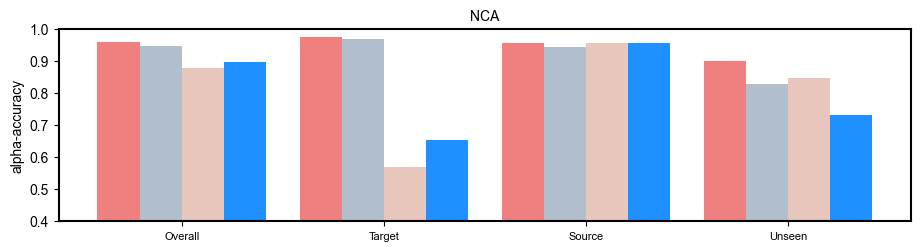

In [8]:
NCA_target_condition = 'NCA_CY25-1_1-' # 模仿DA setting下的target domain的工况
# For NCA
NCA_args_path = './results/NCA_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm8_nh4_el1_dl2_df2_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossawmse_vallossnw_dp0.0_bs32_wd0_mb0.25_agamma0.25_lradjtype4_0'
NCA_old_args_path =  './results/NCA_Informer_Batteries_cycle_SLMove_lr0.005_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm8_nh4_el1_dl2_df4_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossmse_vallossnw_dp0.0_bs32_wd0_mb2_agamma0.25_lradjtype4_0' 
NCA_woTTL_args_path = './results/NCA_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm8_nh4_el2_dl2_df2_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_losswmse_vallossnw_dp0.0_bs32_wd0_mb0.25_agamma0.25_lradjtype4_0'
NCA_woDG_args_path = './results/NCA_Informer_Batteries_cycle_SLMove_lr0.005_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm8_nh4_el1_dl2_df4_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossamse_vallossnw_dp0.0_bs32_wd0_mb0.1_agamma0.05_lradjtype4_0'

# For LFP
LFP_args_path = './results/NE_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.0075_mavg15_ftM_sl20_ll20_pl500_dm12_nh4_el2_dl2_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_lossawmse_vallossnw_dp0.0_bs128_wd0_mb2_agamma0.2_lradjtype4_0'
LFP_old_args_path = './results/NE_Informer_Batteries_cycle_SLMove_lr0.0075_metalr0.0_mavg15_ftM_sl20_ll20_pl500_dm12_nh4_el1_dl1_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_lossmse_vallossnw_dp0.0_bs128_wd0_mb0.002_agamma0.02_lradjtype4_0'
LFP_woTTL_args_path = './results/NE_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.0075_mavg15_ftM_sl20_ll20_pl500_dm12_nh4_el1_dl2_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_losswmse_vallossnw_dp0.0_bs128_wd0.0001_mb2_agamma0.2_lradjtype4_0'
LFP_woDG_args_path = './results/NE_Informer_Batteries_cycle_SLMove_lr0.0075_metalr0.0075_mavg15_ftM_sl20_ll20_pl500_dm12_nh4_el1_dl2_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_lossawmse_vallossnw_dp0.0_bs128_wd0.0001_mb2_agamma0.2_lradjtype4_0'
NCA_model_paths = return_model_paths(NCA_args_path,NCA_old_args_path,NCA_woDG_args_path,NCA_woTTL_args_path)
LFP_model_paths = return_model_paths(LFP_args_path, LFP_old_args_path, LFP_woDG_args_path, LFP_woTTL_args_path)
plot_ablation_study(NCA_model_paths,LFP_model_paths,NCA_target_condition,fixed_files.NE_unseen_test_files)